In [4]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from pyemd import emd
from sklearn.metrics import log_loss

## Manipulating string 

In [2]:
newtrain = pd.read_csv("../data/newtrain.csv")

In [5]:
newtrain['question1'] = newtrain['question1'].apply(lambda s: re.sub(r"\', '"," ", s)).apply(lambda x: x[2:-2])
newtrain['question2'] = newtrain['question2'].apply(lambda s: re.sub(r"\', '"," ", s)).apply(lambda x: x[2:-2])

In [6]:
#drop empty cells
newtrain['question1'].replace('', np.nan, inplace=True)
newtrain['question2'].replace('', np.nan, inplace=True)
newtrain.dropna(subset=['question1', 'question2'], inplace = True)

# Simplest Word Frequency

In [7]:
WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
     intersection = set(vec1.keys()) & set(vec2.keys())
     numerator = sum([vec1[x] * vec2[x] for x in intersection])

     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
     denominator = math.sqrt(sum1) * math.sqrt(sum2)

     if not denominator:
        return 0.0
     else:
        return float(numerator) / denominator
    
def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)

In [8]:
# example

text1 = 'This is a foo bar sentence .'
text2 = 'This sentence is similar to a foo bar sentence .'

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

get_cosine(vector1, vector2)

0.8616404368553293

In [9]:
# apply to the whole data
freq_q1 = newtrain.question1.apply(text_to_vector)
freq_q2 = newtrain.question2.apply(text_to_vector)

In [10]:
words_freq = pd.DataFrame(newtrain.is_duplicate, index = newtrain.index)

In [11]:
estimated = []
for i in range(len(newtrain)):
    estimated.append(get_cosine(freq_q1.iloc[i], freq_q2.iloc[i]))
words_freq['estimated'] = estimated

In [12]:
words_freq[words_freq.is_duplicate == 1].head()

,is_duplicate,estimated
5,1,0.545455
7,1,0.408248
11,1,0.866025
12,1,0.750000
13,1,1.000000


In [14]:
sigS = 1/(1+np.exp(-words_freq.estimated))
pred_accuracy = []
for t in np.arange(0,1,0.05):
    prediction = []
    prediction.append(np.where(sigS > t,1,0))
    pred_accuracy.append(sum(prediction[0] == words_freq.is_duplicate)/len(words_freq))  

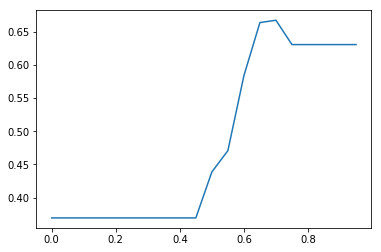

In [86]:
plt.plot(np.arange(0,1,0.05), pred_accuracy)

In [15]:
# set the treshold as 0.65
prediction = []
prediction.append(np.where(sigS > 0.65,1,0))
pred_accuracy = (sum(prediction[0] == words_freq.is_duplicate))/len(words_freq)
pred_accuracy # 0.664

0.6639766458029243

In [29]:
# log loss
log_loss(list(words_freq.is_duplicate), list(prediction[0]))

11.606013929268812

# Word Mover's Distance Algorithm

In [30]:
#load word2vec model, here GoogleNews is used
model = gensim.models.KeyedVectors.load_word2vec_format('../../../../GoogleNews-vectors-negative300.bin', binary=True)

In [31]:
#two sample sentences 
s1 = 'the first sentence'
s2 = 'the second text'

#calculate distance between two sentences using WMD algorithm
distance = model.wmdistance(newtrain.question1.iloc[10], newtrain.question2.iloc[10])

print ('distance = %.3f' % distance)

distance = 1.029


In [33]:
# apply to the whole data
distance = []
for i in range(len(newtrain)):
    distance.append(model.wmdistance(newtrain.question1.iloc[i], newtrain.question2.iloc[i]))

In [34]:
word_distance = pd.DataFrame({'is_duplicate' : newtrain.is_duplicate, 'distance' : distance}, index = newtrain.index)

In [35]:
sigS = 1/(1+np.exp(-word_distance.distance))
pred_accuracy = []
for t in np.arange(0,1,0.05):
    prediction = []
    prediction.append(np.where(sigS > t,1,0))
    pred_accuracy.append(sum(prediction[0] == word_distance.is_duplicate)/len(word_distance))  

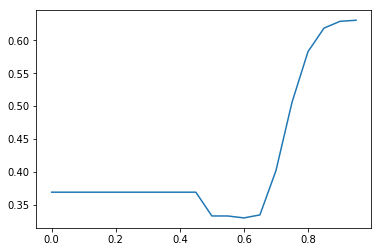

In [69]:
plt.plot(np.arange(0,1,0.05), pred_accuracy)

In [36]:
# set the treshold as 0.9
prediction = []
prediction.append(np.where(sigS > 0.9,1,0))
pred_accuracy = (sum(prediction[0] == word_distance.is_duplicate))/len(word_distance)
pred_accuracy # 0.629

0.6290294648821158

In [37]:
# log loss
log_loss(list(word_distance.is_duplicate), list(prediction[0]))

12.812869793734436